## Second order model
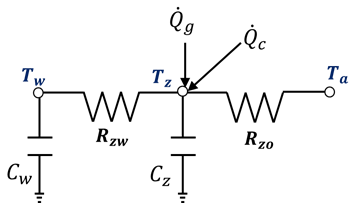

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.optimize import minimize
import tqdm

In [4]:
import matplotlib
font = {'family' : 'Times New Roman',
        'size'   : 16}

matplotlib.rc('font', **font)

plt.rcParams['figure.figsize'] = (12,5)

In [5]:
def KFilter1(num,z,A,mu0,Sigma0,Phi,Ups,Gam,cQ,cR,inp):
    # Note: Must give cholesky decomp: cQ = np.linalg.choleske(Q),cR = np.linalg.choleske(R)
    Q = np.dot(cQ.T,cQ)
    R = np.dot(cR.T,cR)
    
    
    # z is num by q (time=row series=col) 
    # input is num by r (use 0 if not needed) 
    # A is an array with dim=c(q,p,num)
    # Ups is p by r (use 0 if not needed) Gam is q by r (use 0 if not needed)
    # R is q by q 
    # mu0 is p by 1 
    # Sigma0, Phi, Q are p by p,   Constant.
    Phi,z,inp = np.array(Phi),np.array(z), np.array(inp)
    pdim = Phi.shape[0]
    qdim = z.shape[1]  #
    rdim = inp.shape[1]  # 
    
    if np.max(np.abs(Ups)) == 0:
        Ups = np.zeros((pdim,rdim))
    if np.max(np.abs(Gam)) == 0:
        Gam = np.zeros((qdim,rdim))
    
    xp, xf = np.zeros([num,pdim,1]), np.zeros([num,pdim,1])  # Store the results
    Pp,Pf = np.zeros([num,pdim,pdim]), np.zeros([num,pdim,pdim])
    innov,sig = np.zeros([num,qdim,1]), np.zeros([num,qdim,qdim]) # Innovations, and the covariance matrix
    
    # Initialize
    x0,Sigma0 = np.array(mu0),np.array(Sigma0)
    xp[0] = np.dot(Phi,mu0) + np.dot(Ups,inp[0]) 
    Pp[0] = np.dot(np.dot(Phi, Sigma0),Phi.T) + Q
    
    A_cur = A[0]
    sigtemp = np.dot(np.dot(A_cur,Pp[0]),A_cur.T) + R
    sig[0] = (sigtemp.T +sigtemp) / 2
    
    sigInv = np.linalg.inv(sig[0])
    
    K = np.dot(np.dot(Pp[0], A_cur.T), sigInv)
    innov[0] = z[0] - np.dot(A_cur,xp[0]) - np.dot(Gam,inp[0])
    
    ## update
    xf[0] = xp[0] + np.dot(K,innov[0])
    Pf[0] = Pp[0] - np.dot(np.dot(K,A_cur),Pp[0])
    
    den = (1/np.sqrt(np.linalg.det(sig[0]))/(2*math.pi)**.5)
    if den == 0:
        den = den+10**(-300)
        print('Zer0 Encountered')
    like = -np.log(den) -( -.5 * np.dot(np.dot(innov[0].T,sigInv),innov[0]))  #-log(Likelihood)
    
    for i in range(1,num):
        xp[i] = np.dot(Phi,xf[i-1]) + np.dot(Ups,inp[i])
        Pp[i] = np.dot(np.dot(Phi, Pf[i-1]),Phi.T) + Q
        
        A_cur = A[i]
        sigtemp = np.dot(np.dot(A_cur,Pp[i]),A_cur.T) + R
        sig[i] = (sigtemp.T +sigtemp) / 2

        sigInv = np.linalg.inv(sig[i])

        K = np.dot(np.dot(Pp[i], A_cur.T), sigInv)
        innov[i] = z[i] - np.dot(A_cur,xp[i]) - np.dot(Gam,inp[i])

        ## update
        xf[i] = xp[i] + np.dot(K,innov[i])
        Pf[i] = Pp[i] - np.dot(np.dot(K,A_cur),Pp[i])
           
        den = (1/np.sqrt(np.linalg.det(sig[i]))/(2*math.pi)**.5)
        like = like - np.log(den) -( -.5 * np.dot(np.dot(innov[i].T,sigInv),innov[i])) #-log(Likelihood), very small zero!!!
    # Output
    re = {}
    re['like'] = like
    re['xp'] = xp
    re['xf'] = xf
    re['Pp'] = Pp
    re['Pf'] = Pf
    re['innov'] = innov
    re['Sig'] = sig          
           
    return re

## 1. data preparation

In [6]:
dat_DF = pd.read_csv(r"..\Modeling\Data\Amita\minute.csv")

In [7]:
dat_DF.head()

,Unnamed: 0,Unix Time (s),Local Time,ouPresentCompressorFreq,ouTemperatureOutdoor,iuAirFlowRate,tabTsense0,humidityIndoor.0,Liq. T.,Suc. T.,...,IDWB,Speed_sq,ID Flowrate_sq,IDDB_sq,IDWB_sq,ODDB_sq,SensibleCapacity,Predict Sensible Capacity,Predicted Comp. Power,Actual Comp. Power
0,43892,1.531389e+09,7/12/18 4:54,0.0,80.4,0.0,74.1,54.0,74.676505,75.061364,...,62.989692,0.0,0.0,5490.81,3967.701242,6464.16,0.000000,0.000000,0.000000,0.000
1,43893,1.531389e+09,7/12/18 4:55,0.0,79.6,0.0,74.1,54.0,75.012050,75.198137,...,62.989692,0.0,0.0,5490.81,3967.701242,6336.16,0.000000,0.000000,0.000000,0.000
2,43894,1.531389e+09,7/12/18 4:56,0.0,79.2,0.0,74.1,54.0,75.161585,75.280482,...,62.989692,0.0,0.0,5490.81,3967.701242,6272.64,0.000000,0.000000,0.000000,0.000
3,43895,1.531389e+09,7/12/18 4:57,0.0,79.0,577.0,74.0,54.0,76.854074,66.670983,...,62.905096,0.0,332929.0,5476.00,3957.051073,6241.00,0.000000,0.000000,0.000000,0.000
4,43896,1.531389e+09,7/12/18 4:58,33.0,79.3,577.0,73.9,54.5,86.507454,47.798319,...,62.956721,1089.0,332929.0,5461.21,3963.548677,6288.49,7872.652539,18347.185743,1515.464186,1657.102


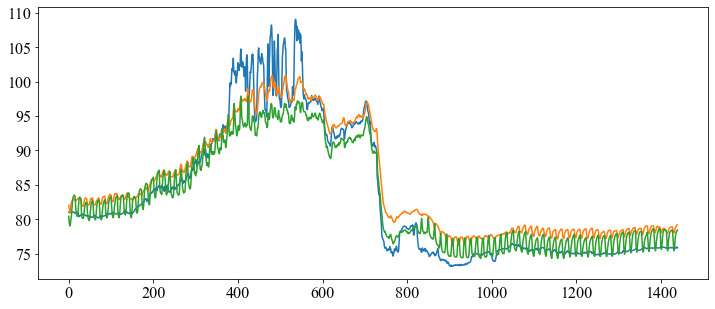

In [8]:
plt.plot(dat_DF['OAT Sun T.'].iloc[:1440])
plt.plot(dat_DF['OAT Shade T.'].iloc[:1440])
plt.plot(dat_DF['ouTemperatureOutdoor'].iloc[:1440])

## 2. Model 1
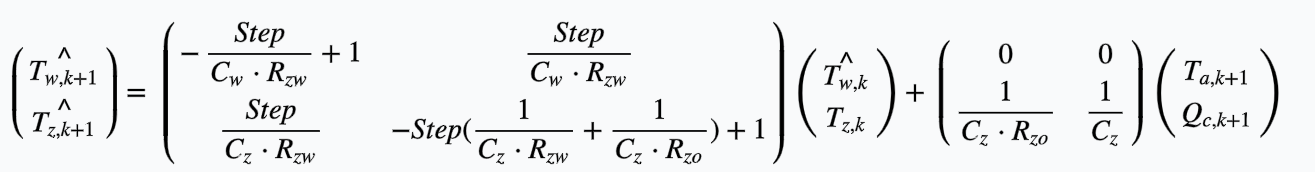

Actually, the first will be viewed as state transition process

### 1) Travis's data

In [9]:
dat_DF = pd.read_csv(r"..\Modeling\Data\Amita\DataSet2\Travis_af.csv")

#### <span style="color:red">Step1:</span> Find a period during which no cooling is required and the space is not occupied.
* No cooling
* Unoccupied: this could viewed as no internal heat gain(Light, Appliance, and occupant) 
* night: no lighting, appliance,and all occupants are supposed to fall asleep

10pm ~5am

In [10]:
h,l = dat_DF.shape

In [11]:
dat_DF.columns

Index(['Unnamed: 0', 'Local Time', 'ouTemperatureOutdoor', 'ouInputVoltage',
       'ouInputCurrent', 'ouPresentCompressorFreq', 'iuAirFlowRate', 'iuDAT',
       'tabTsense0', 'setpointCooling.0', 'humidityIndoor.0',
       'SensibleCapacity', 'tabTsense0_Category'],
      dtype='object')

Text(0.5, 1.0, 'OA')

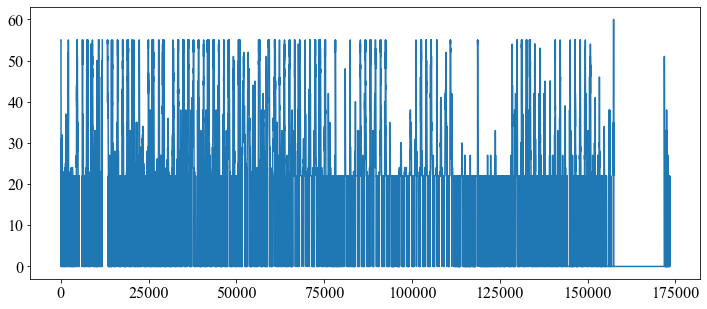

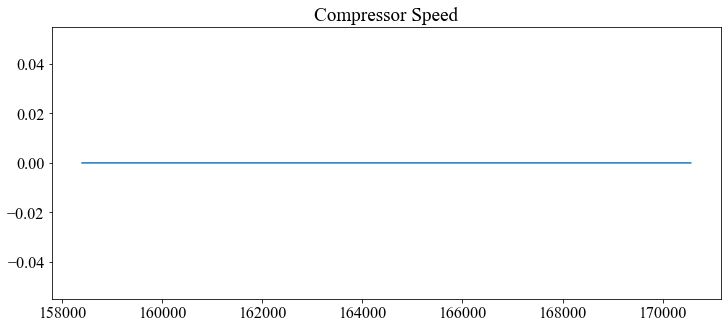

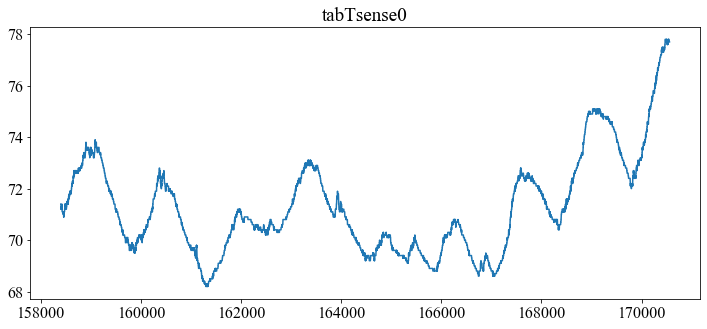

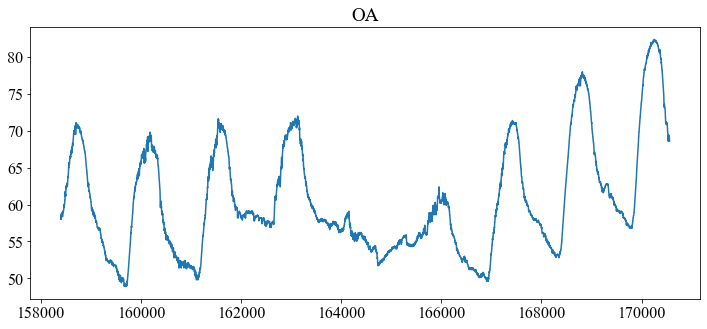

In [12]:
plt.plot(dat_DF['ouPresentCompressorFreq'])

plt.figure()
ax = plt.subplot()
plt.plot(dat_DF['ouPresentCompressorFreq'].iloc[144000+14400:172000-1440])
ax.set_title('Compressor Speed')

plt.figure()
ax = plt.subplot()
plt.plot(dat_DF['tabTsense0'].iloc[144000+14400:172000-1440])
ax.set_title('tabTsense0')

plt.figure()
ax = plt.subplot()
plt.plot(dat_DF['ouTemperatureOutdoor'].iloc[144000+14400:172000-1440])
ax.set_title('OA')

In [13]:
dat_DF['const_1'] = dat_DF['ouTemperatureOutdoor']
dat_DF['const_0'] = dat_DF['ouTemperatureOutdoor']
for i in tqdm.tqdm(range(h)):
    dat_DF['const_1'].iloc[i] = 1
    dat_DF['const_0'].iloc[i] = 0

  0%|                                                                                       | 0/173344 [00:00<?, ?it/s]C:\Users\ff9708\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
100%|████████████████████████████████████████████████████████████████████████| 173344/173344 [01:38<00:00, 1766.38it/s]


##### Group 1

In [16]:
def object_fun1(par): 
    Phi = np.eye(2)
    Phi[0,0] = -1/(par[0]*par[2])+1
    Phi[0,1] = 1/(par[0]*par[2])
    Phi[1,0] = 1/(par[1]*par[2])
    Phi[1,1] = -1*(1/(par[1]*par[2]) + 1/(par[1]*par[3]))+1
    
    Ups = np.eye(2)  # Two input: Ambient temperautre, and Q_g
    Ups[0,0] = 0
    Ups[0,1] = 0
    Ups[1,0] = 1/(par[1]*par[3])    
    Ups[1,1] = 1/(par[1])    
    
    cQ = np.eye(2)
    cQ[0,0] = par[4]
    cQ[1,1] = par[5]
                
    #Observation process
    A = np.array([[[0,1]]] * nrow)
    cR = np.array([[0]])
    
    #
    kf = KFilter1(nrow,z_train,A,mu0,sigma0,Phi,Ups,np.array([[0]]),cQ,cR,inp)
        
    return kf['like']

###### Case 1: 10/20 10pm ~10/21 5am

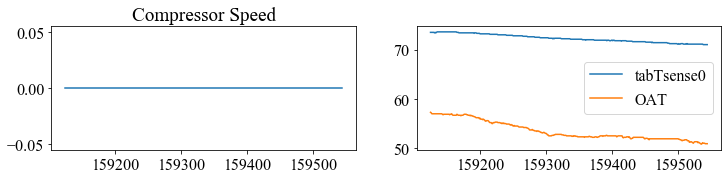

In [17]:
ax = plt.subplot(2,2,1)
plt.plot(dat_DF['ouPresentCompressorFreq'].iloc[159125:159125+7*60])
ax.set_title('Compressor Speed')

ax = plt.subplot(2,2,2)
plt.plot(dat_DF['tabTsense0'].iloc[159125:159125+7*60])
plt.plot(dat_DF['ouTemperatureOutdoor'].iloc[159125:159125+7*60])
ax.legend(['tabTsense0','OAT'])

In [18]:
dat_DF['Local Time'].iloc[[159125,159125+7*60]]

159125    10/20/2018 22:01
159545     10/21/2018 5:01
Name: Local Time, dtype: object

In [19]:
z_train = np.reshape(np.array(dat_DF['tabTsense0'].iloc[159125:159125+7*60]),[-1,1])

nrow = len(z_train)

inp = np.reshape(np.array(dat_DF[['ouTemperatureOutdoor','const_0']].iloc[159125:159125+7*60]),[-1,2,1])

# Initial value
mu0 = [[dat_DF['tabTsense0'].iloc[159124]],[dat_DF['tabTsense0'].iloc[159124]]]
sigma0 = np.eye(2)

In [20]:
init_par = [1,1,1,1,1,1]
object_fun1(init_par)

array([[37986.26104045]])

In [21]:
#bound
bnds = ((0.1, None), (0, None),(0, None),(0, None),(None, None),(None, None))
res = minimize(object_fun1,init_par,method = 'L-BFGS-B',bounds = bnds)

In [22]:
res

      fun: array([[-792.97186008]])
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 3.29691829e-04, -3.41060513e-05,  4.54747351e-05, -1.36424205e-04,
       -5.05906428e-03, -1.35318032e+00])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 497
      nit: 42
   status: 0
  success: True
        x: array([ 4.35323760e+01,  6.33609507e+01,  7.34507972e+01,  4.72342468e+01,
       -1.88894907e-03, -3.63846201e-02])

In [23]:
par_list = [[ 3.77942674e+01,  6.21937564e+01,  5.78701421e+01,  4.86944510e+01,
        1.21433866e-03, -3.63820435e-02]]

###### Case 2: 10/21 10pm ~10/22 5am

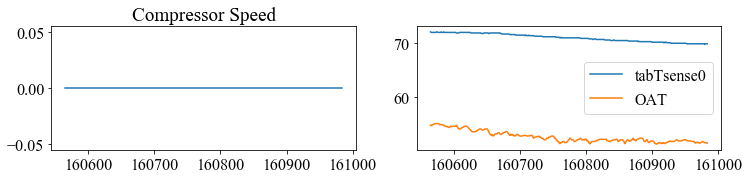

In [43]:
ax = plt.subplot(2,2,1)
plt.plot(dat_DF['ouPresentCompressorFreq'].iloc[160565:160565+7*60])
ax.set_title('Compressor Speed')

ax = plt.subplot(2,2,2)
plt.plot(dat_DF['tabTsense0'].iloc[160565:160565+7*60])
plt.plot(dat_DF['ouTemperatureOutdoor'].iloc[160565:160565+7*60])
ax.legend(['tabTsense0','OAT'])

In [168]:
dat_DF['Local Time'].iloc[[160565,160565+7*60]]

160565    10/21/2018 22:01
160985     10/22/2018 5:01
Name: Local Time, dtype: object

In [169]:
z_train = np.reshape(np.array(dat_DF['tabTsense0'].iloc[160565:160565+7*60]),[-1,1])

nrow = len(z_train)

inp = np.reshape(np.array(dat_DF[['ouTemperatureOutdoor','const_0']].iloc[160565:160565+7*60]),[-1,2,1])


mu0 = [[dat_DF['tabTsense0'].iloc[160564]],[dat_DF['tabTsense0'].iloc[160564]]]
sigma0 = np.eye(2)
# Function to Calculate Likelihood


In [170]:
init_par = [1,1,1,1,1,1]
object_fun1(init_par)

array([[35548.33416545]])

In [171]:
#bound
bnds = ((0.1, None), (0.1, None),(0.1, None),(0.1, None),(None, None),(None, None))
res = minimize(object_fun1,init_par,method = 'L-BFGS-B',bounds = bnds)

In [172]:
res

      fun: array([[-811.36219802]])
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.04636308e-04,  1.39834810e-03,  9.77706804e-04,  3.29691829e-04,
       -1.23918653e-03,  2.89878699e-01])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 560
      nit: 52
   status: 0
  success: True
        x: array([ 3.88546555e+01,  6.50594606e+01,  6.76082069e+01,  5.03316517e+01,
       -4.46230389e-04, -3.48197421e-02])

In [173]:
par_list.append([ 3.88546555e+01,  6.50594606e+01,  6.76082069e+01,  5.03316517e+01,
       -4.46230389e-04, -3.48197421e-02])

###### Case 3: 10/22 10pm ~10/23 5am

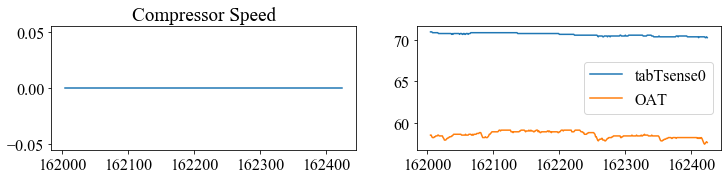

In [174]:
ax = plt.subplot(2,2,1)
plt.plot(dat_DF['ouPresentCompressorFreq'].iloc[162005:162005+7*60])
ax.set_title('Compressor Speed')

ax = plt.subplot(2,2,2)
plt.plot(dat_DF['tabTsense0'].iloc[162005:162005+7*60])
plt.plot(dat_DF['ouTemperatureOutdoor'].iloc[162005:162005+7*60])
ax.legend(['tabTsense0','OAT'])

In [175]:
dat_DF['Local Time'].iloc[[162005,162005+7*60]]

162005    10/22/2018 22:01
162425     10/23/2018 5:01
Name: Local Time, dtype: object

In [176]:
dat_DF['tabTsense0'].iloc[162005:162005+7*60]

162005    71.0
162006    71.0
162007    71.0
162008    70.9
162009    70.9
          ... 
162420    70.4
162421    70.3
162422    70.3
162423    70.4
162424    70.3
Name: tabTsense0, Length: 420, dtype: float64

In [177]:
dat_DF['tabTsense0'].iloc[160565:1605655+7*60]

160565    72.0
160566    71.9
160567    71.9
160568    71.9
160569    71.9
          ... 
173339    73.7
173340    73.8
173341    73.8
173342    73.8
173343    73.8
Name: tabTsense0, Length: 12779, dtype: float64

In [178]:
z_train = np.reshape(np.array(dat_DF['tabTsense0'].iloc[162005:162005+7*60]),[-1,1])

nrow = len(z_train)

inp = np.reshape(np.array(dat_DF[['ouTemperatureOutdoor','const_0']].iloc[162005:162005+7*60]),[-1,2,1])


mu0 = [[dat_DF['tabTsense0'].iloc[162004]],[dat_DF['tabTsense0'].iloc[162004]]]
sigma0 = np.eye(2)
# Function to Calculate Likelihood


In [179]:
init_par = [1,1,1,1,1,1]
object_fun1(init_par)

array([[15978.42916545]])

In [180]:
#bound
bnds = ((0.1, None), (0, None),(0, None),(0, None),(None, None),(None, None))

res = minimize(object_fun1,init_par,method = 'L-BFGS-B',bounds=bnds)

In [181]:
res

      fun: array([[-828.25179159]])
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3.41060513e-05,  7.04858394e-04,  6.82121026e-05,  7.27595761e-04,
       -7.63975549e-03,  1.25123734e-01])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 364
      nit: 35
   status: 0
  success: True
        x: array([ 5.36380036e+01,  9.04850930e+01,  8.33387746e+01,  7.31368168e+01,
       -6.27316400e-03, -3.34443238e-02])

In [182]:
par_list.append([5.36380036e+01,  9.04850930e+01,  8.33387746e+01,  7.31368168e+01,
       -6.27316400e-03, -3.34443238e-02])

In [183]:
par_list

[[37.7942674, 62.1937564, 57.8701421, 48.694451, 0.00121433866, -0.0363820435],
 [38.8546555,
  65.0594606,
  67.6082069,
  50.3316517,
  -0.000446230389,
  -0.0348197421],
 [53.6380036, 90.485093, 83.3387746, 73.1368168, -0.006273164, -0.0334443238]]

In [262]:
par_DF = pd.DataFrame(par_list,columns = ['C_w','C_z','R_zw','R_zo','cQ1','cQ2'],index = ['10/20','10/21','10/22'])

In [263]:
par_DF

,C_w,C_z,R_zw,R_zo,cQ1,cQ2
10/20,37.794267,62.193756,57.870142,48.694451,0.001214,-0.036382
10/21,38.854655,65.059461,67.608207,50.331652,-0.000446,-0.034820
10/22,53.638004,90.485093,83.338775,73.136817,-0.006273,-0.033444


###### Test1: 10/23 10 pm ~10/24 5am

In [264]:
par = par_DF.iloc[1,:]

In [265]:
## Prediction validation

Phi = np.eye(2)
Phi[0,0] = -1/(par[0]*par[2])+1
Phi[0,1] = 1/(par[0]*par[2])
Phi[1,0] = 1/(par[1]*par[2])
Phi[1,1] = -1*(1/(par[1]*par[2]) + 1/(par[1]*par[3]))+1

Ups = np.eye(2)  # Two input: Ambient temperautre, and Q_g
Ups[0,0] = 0
Ups[0,1] = 0
Ups[1,0] = 1/(par[1]*par[3])    
Ups[1,1] = 1/(par[1])    

cQ = np.eye(2)
cQ[0,0] = par[4]
cQ[1,1] = par[5]

#Observation process
A = np.array([[[0,1]]] * nrow)
cR = np.array([[0]])

In [266]:
test = dat_DF['tabTsense0'].iloc[163445:163445+7*60]

pred = [dat_DF['tabTsense0'].iloc[163444]]
prev_T = np.array([[pred[-1]],[pred[-1]]])

for i in range(len(test)):
    inp = np.array([[dat_DF['ouTemperatureOutdoor'].iloc[163445+i]],[0]])
    cur_T = np.dot(Phi,prev_T) + np.dot(Ups,inp)
    #print(cur_T)
    pred.append(cur_T[1])
    prev_T = cur_T

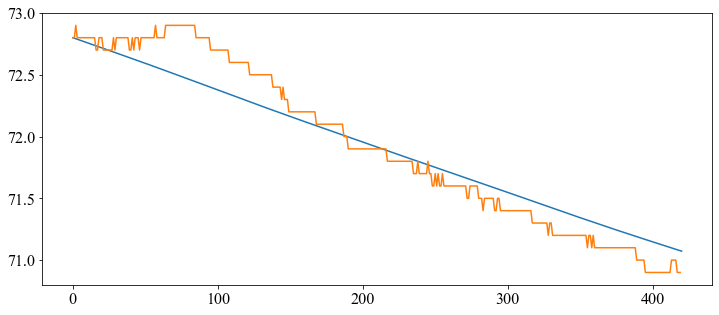

In [267]:
plt.plot(pred)
plt.plot(np.arange(len(test)),test)
#plt.plot(np.arange(len(test)),dat_DF['ouTemperatureOutdoor'].iloc[166325:166325+7*60])

###### Test2: 10/24 10 pm ~10/25 5am

In [268]:
163445 + 1440

164885

In [269]:
test = dat_DF['tabTsense0'].iloc[164885:164885+7*60]

pred = [dat_DF['tabTsense0'].iloc[164884]]
prev_T = np.array([[pred[-1]],[pred[-1]]])

for i in range(len(test)):
    inp = np.array([[dat_DF['ouTemperatureOutdoor'].iloc[164885+i]],[0]])
    cur_T = np.dot(Phi,prev_T) + np.dot(Ups,inp)
    #print(cur_T)
    pred.append(cur_T[1])
    prev_T = cur_T

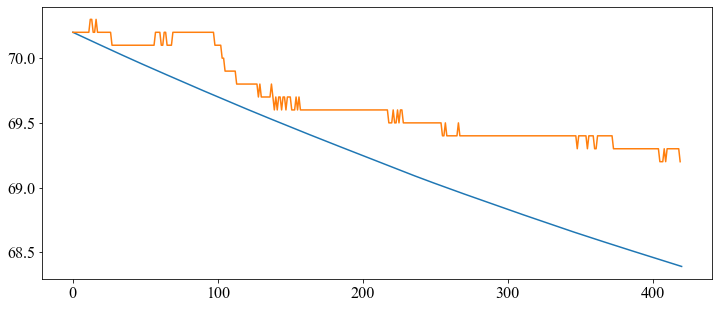

In [270]:
plt.plot(pred)
plt.plot(np.arange(len(test)),test)
#plt.plot(np.arange(len(test)),dat_DF['ouTemperatureOutdoor'].iloc[166325:166325+7*60])

###### Test3: 10/25 10 pm ~10/26 5am

In [271]:
163445 + 1440 +1440

166325

In [272]:
test = dat_DF['tabTsense0'].iloc[166325:166325+7*60]

pred = [dat_DF['tabTsense0'].iloc[166324]]
prev_T = np.array([[pred[-1]],[pred[-1]]])

for i in range(len(test)):
    inp = np.array([[dat_DF['ouTemperatureOutdoor'].iloc[166325+i]],[0]])
    cur_T = np.dot(Phi,prev_T) + np.dot(Ups,inp)
    #print(cur_T)
    pred.append(cur_T[1])
    prev_T = cur_T

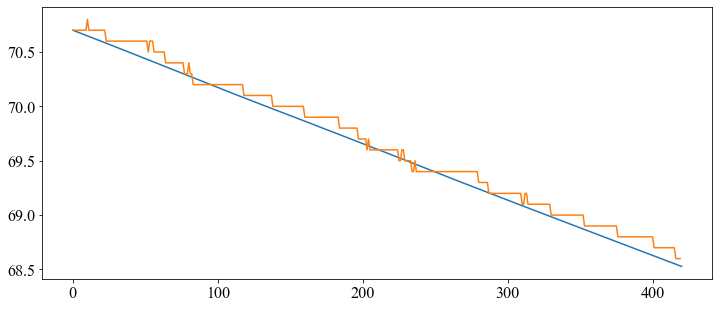

In [273]:
plt.plot(pred)
plt.plot(np.arange(len(test)),test)
#plt.plot(np.arange(len(test)),dat_DF['ouTemperatureOutdoor'].iloc[166325:166325+7*60])

##### Group 2

In [196]:
def object_fun2(par): 
    Phi = np.eye(2)
    Phi[0,0] = -1/(par[0]*par[2])+1
    Phi[0,1] = 1/(par[0]*par[2])
    Phi[1,0] = 1/(par[1]*par[2])
    Phi[1,1] = -1*(1/(par[1]*par[2]) + 1/(par[1]*par[3]))+1
    
    Ups = np.eye(2)  # Two input: Ambient temperautre, and Q_g
    Ups[0,0] = 0
    Ups[0,1] = 0
    Ups[1,0] = 1/(par[1]*par[3])    
    Ups[1,1] = par[6]/(par[1])    
    
    cQ = np.eye(2)
    cQ[0,0] = par[4]
    cQ[1,1] = par[5]
                
    #Observation process
    A = np.array([[[0,1]]] * nrow)
    cR = np.array([[0]])
    
    
    kf = KFilter1(nrow,z_train,A,mu0,sigma0,Phi,Ups,np.array([[0]]),cQ,cR,inp)
        
    return kf['like']

###### Case 1: 10/20 10pm ~10/21 5am

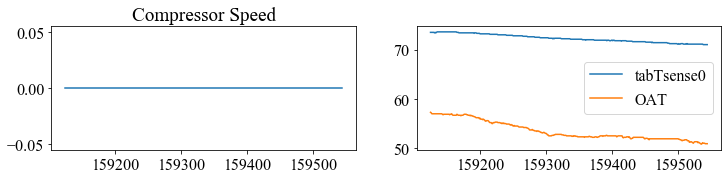

In [197]:
ax = plt.subplot(2,2,1)
plt.plot(dat_DF['ouPresentCompressorFreq'].iloc[159125:159125+7*60])
ax.set_title('Compressor Speed')

ax = plt.subplot(2,2,2)
plt.plot(dat_DF['tabTsense0'].iloc[159125:159125+7*60])
plt.plot(dat_DF['ouTemperatureOutdoor'].iloc[159125:159125+7*60])
ax.legend(['tabTsense0','OAT'])

In [198]:
dat_DF['Local Time'].iloc[[159125,159125+7*60]]

159125    10/20/2018 22:01
159545     10/21/2018 5:01
Name: Local Time, dtype: object

In [199]:
z_train = np.reshape(np.array(dat_DF['tabTsense0'].iloc[159125:159125+7*60]),[-1,1])

nrow = len(z_train)

inp = np.reshape(np.array(dat_DF[['ouTemperatureOutdoor','const_1']].iloc[159125:159125+7*60]),[-1,2,1])


mu0 = [[dat_DF['tabTsense0'].iloc[15124]],[dat_DF['tabTsense0'].iloc[15124]]]
sigma0 = np.eye(2)
# Function to Calculate Likelihood


In [200]:
init_par = [1,1,1,1,1,1,1]
object_fun2(init_par)

array([[34136.94104045]])

In [201]:
#bound
bnds = ((0.1, None), (0, None),(0, None),(0, None),(None, None),(None, None),(None, None))
res = minimize(object_fun2,init_par,method = 'L-BFGS-B',bounds = bnds)

In [202]:
res

      fun: array([[-793.08501876]])
 hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>
      jac: array([-8.41282599e-04, -2.04636308e-04,  4.99085218e-03, -9.98170435e-03,
        4.07567313e-02,  4.96930852e+00,  6.26982910e-02])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 632
      nit: 51
   status: 0
  success: True
        x: array([ 1.49586709e+01,  3.51750476e+01,  4.54942268e+01,  1.54581975e+01,
        2.80280788e-03, -3.63491767e-02,  9.99162344e-01])

In [203]:
par_list2 = [[ 1.49586709e+01,  3.51750476e+01,  4.54942268e+01,  1.54581975e+01,
        2.80280788e-03, -3.63491767e-02,  9.99162344e-01]]

###### Case 2: 10/21 10pm ~10/22 5am

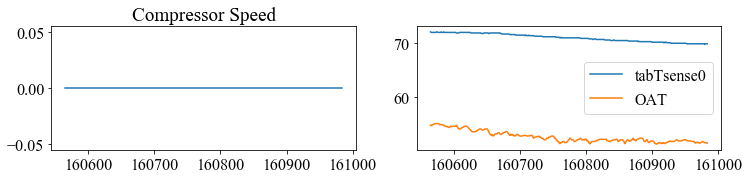

In [104]:
ax = plt.subplot(2,2,1)
plt.plot(dat_DF['ouPresentCompressorFreq'].iloc[160565:160565+7*60])
ax.set_title('Compressor Speed')

ax = plt.subplot(2,2,2)
plt.plot(dat_DF['tabTsense0'].iloc[160565:160565+7*60])
plt.plot(dat_DF['ouTemperatureOutdoor'].iloc[160565:160565+7*60])
ax.legend(['tabTsense0','OAT'])

In [105]:
dat_DF['Local Time'].iloc[[160565,160565+7*60]]

160565    10/21/2018 22:01
160985     10/22/2018 5:01
Name: Local Time, dtype: object

In [107]:
z_train = np.reshape(np.array(dat_DF['tabTsense0'].iloc[160565:160565+7*60]),[-1,1])

nrow = len(z_train)

inp = np.reshape(np.array(dat_DF[['ouTemperatureOutdoor','const_1']].iloc[160565:160565+7*60]),[-1,2,1])


mu0 = [[dat_DF['tabTsense0'].iloc[160564]],[dat_DF['tabTsense0'].iloc[160564]]]
sigma0 = np.eye(2)
# Function to Calculate Likelihood


In [108]:
init_par = [1,1,1,1,1,1,1]
object_fun2(init_par)

array([[31820.08416545]])

In [110]:
#bound
bnds = ((0.1, None), (0.1, None),(0.1, None),(0.1, None),(None, None),(None, None),(None, None))
res = minimize(object_fun,init_par,method = 'L-BFGS-B',bounds = bnds)

In [111]:
res

      fun: array([[-839.86514878]])
 hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.93267624e-04,  1.94404493e-03,  4.33601599e-02, -1.95541361e-02,
        2.75542789e-01, -2.63469246e-01, -1.41881173e-01])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 1352
      nit: 117
   status: 0
  success: True
        x: array([14.06296429,  6.12020678,  0.39349379, 11.42518044,  0.01570697,
       -0.0307133 ,  1.49840946])

In [204]:
par_list2.append([14.06296429,  6.12020678,  0.39349379, 11.42518044,  0.01570697,
       -0.0307133 ,  1.49840946])

###### Case 3: 10/22 10pm ~10/23 6am

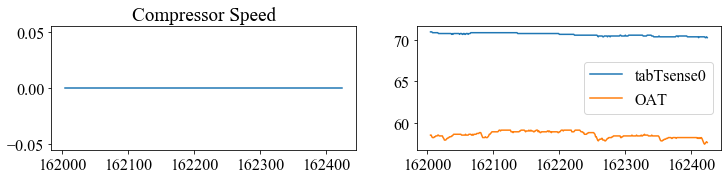

In [113]:
ax = plt.subplot(2,2,1)
plt.plot(dat_DF['ouPresentCompressorFreq'].iloc[162005:162005+7*60])
ax.set_title('Compressor Speed')

ax = plt.subplot(2,2,2)
plt.plot(dat_DF['tabTsense0'].iloc[162005:162005+7*60])
plt.plot(dat_DF['ouTemperatureOutdoor'].iloc[162005:162005+7*60])
ax.legend(['tabTsense0','OAT'])

In [114]:
z_train = np.reshape(np.array(dat_DF['tabTsense0'].iloc[162005:162005+7*60]),[-1,1])

nrow = len(z_train)

inp = np.reshape(np.array(dat_DF[['ouTemperatureOutdoor','const_1']].iloc[162005:162005+7*60]),[-1,2,1])


mu0 = [[dat_DF['tabTsense0'].iloc[162004]],[dat_DF['tabTsense0'].iloc[162004]]]
sigma0 = np.eye(2)
# Function to Calculate Likelihood


In [118]:
init_par = [1,1,1,1,1,1,1]
object_fun2(init_par)

array([[13537.17916545]])

In [121]:
#bound
bnds = ((0.1, None), (0.1, None),(0.1, None),(0.1, None),(None, None),(None, None),(0, None))

res = minimize(object_fun,init_par,method = 'L-BFGS-B',bounds=bnds)

In [122]:
res

      fun: array([[-852.66085821]])
 hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.02103206,  0.00591172, -0.01596163, -0.0086402 , -0.06482423,
       -0.7894414 , -0.72163857])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 2088
      nit: 167
   status: 0
  success: True
        x: array([ 3.12847219e+00,  4.23439749e+00,  6.84649944e-01,  3.19025257e+01,
       -2.02273488e-04,  3.15141830e-02,  3.68582566e-01])

In [205]:
par_list2.append([ 3.12847219e+00,  4.23439749e+00,  6.84649944e-01,  3.19025257e+01,
       -2.02273488e-04,  3.15141830e-02,  3.68582566e-01])

In [206]:
par_list2

[[14.9586709,
  35.1750476,
  45.4942268,
  15.4581975,
  0.00280280788,
  -0.0363491767,
  0.999162344],
 [14.06296429,
  6.12020678,
  0.39349379,
  11.42518044,
  0.01570697,
  -0.0307133,
  1.49840946],
 [3.12847219,
  4.23439749,
  0.684649944,
  31.9025257,
  -0.000202273488,
  0.031514183,
  0.368582566]]

In [210]:
par_DF2 = pd.DataFrame(par_list2,columns = ['C_w','C_z','R_zw','R_zo','cQ1','cQ2','Q_int'],index = ['10/20','10/21','10/22'])

In [211]:
par_DF2

,C_w,C_z,R_zw,R_zo,cQ1,cQ2,Q_int
10/20,14.958671,35.175048,45.494227,15.458198,0.002803,-0.036349,0.999162
10/21,14.062964,6.120207,0.393494,11.425180,0.015707,-0.030713,1.498409
10/22,3.128472,4.234397,0.684650,31.902526,-0.000202,0.031514,0.368583


###### Test1: 10/23 10 pm ~10/24 5am

In [246]:
par = par_DF2.iloc[1,:]

In [1]:
## Prediction validation

Phi = np.eye(2)
Phi[0,0] = -1/(par[0]*par[2])+1
Phi[0,1] = 1/(par[0]*par[2])
Phi[1,0] = 1/(par[1]*par[2])
Phi[1,1] = -1*(1/(par[1]*par[2]) + 1/(par[1]*par[3]))+1

Ups = np.eye(2)  # Two input: Ambient temperautre, and Q_g
Ups[0,0] = 0
Ups[0,1] = 0
Ups[1,0] = 1/(par[1]*par[3])    
Ups[1,1] = par[6]/(par[1])    

cQ = np.eye(2)
cQ[0,0] = par[4]
cQ[1,1] = par[5]

#Observation process
A = np.array([[[0,1]]] * nrow)
cR = np.array([[0]])

NameError: name 'par' is not defined

In [2]:
test = dat_DF['tabTsense0'].iloc[163445:163445+7*60]

pred = [dat_DF['tabTsense0'].iloc[163444]]
prev_T = np.array([[pred[-1]],[pred[-1]]])

for i in range(len(test)):
    inp = np.array([[dat_DF['ouTemperatureOutdoor'].iloc[163445+i]],[1]])
    cur_T = np.dot(Phi,prev_T) + np.dot(Ups,inp)
    #print(cur_T)
    pred.append(cur_T[1])
    prev_T = cur_T

NameError: name 'dat_DF' is not defined

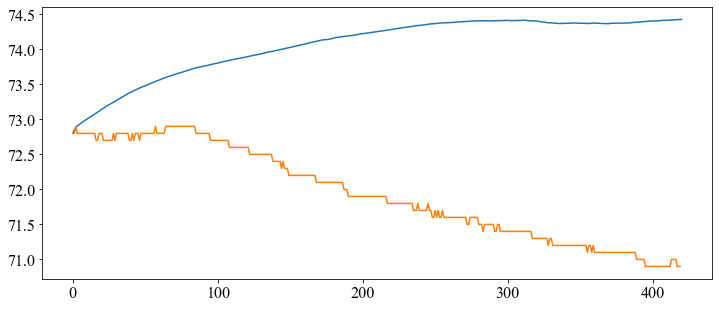

In [249]:
plt.plot(pred)
plt.plot(np.arange(len(test)),test)
#plt.plot(np.arange(len(test)),dat_DF['ouTemperatureOutdoor'].iloc[166325:166325+7*60])

###### Test2: 10/24 10 pm ~10/25 5am

In [250]:
163445 + 1440

164885

In [251]:
test = dat_DF['tabTsense0'].iloc[164885:164885+7*60]

pred = [dat_DF['tabTsense0'].iloc[164884]]
prev_T = np.array([[pred[-1]],[pred[-1]]])

for i in range(len(test)):
    inp = np.array([[dat_DF['ouTemperatureOutdoor'].iloc[164885+i]],[1]])
    cur_T = np.dot(Phi,prev_T) + np.dot(Ups,inp)
    #print(cur_T)
    pred.append(cur_T[1])
    prev_T = cur_T

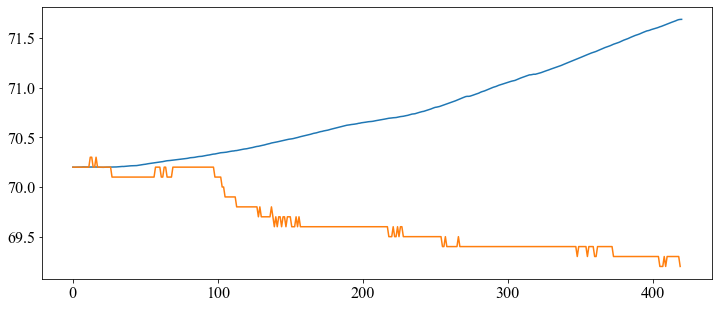

In [252]:
plt.plot(pred)
plt.plot(np.arange(len(test)),test)
#plt.plot(np.arange(len(test)),dat_DF['ouTemperatureOutdoor'].iloc[166325:166325+7*60])

###### Test3: 10/25 10 pm ~10/26 5am

In [253]:
163445 + 1440 +1440

166325

In [254]:
test = dat_DF['tabTsense0'].iloc[166325:166325+7*60]

pred = [dat_DF['tabTsense0'].iloc[166324]]
prev_T = np.array([[pred[-1]],[pred[-1]]])

for i in range(len(test)):
    inp = np.array([[dat_DF['ouTemperatureOutdoor'].iloc[166325+i]],[1]])
    cur_T = np.dot(Phi,prev_T) + np.dot(Ups,inp)
    #print(cur_T)
    pred.append(cur_T[1])
    prev_T = cur_T

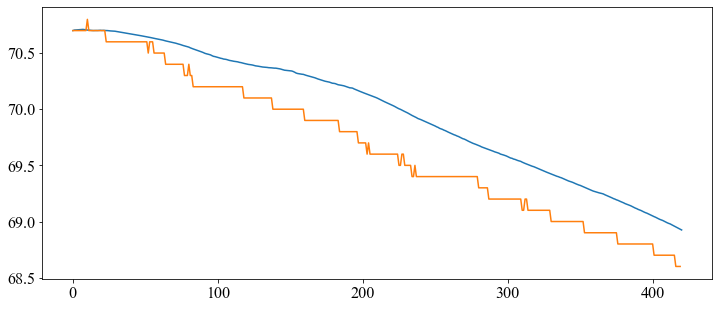

In [255]:
plt.plot(pred)
plt.plot(np.arange(len(test)),test)
#plt.plot(np.arange(len(test)),dat_DF['ouTemperatureOutdoor'].iloc[166325:166325+7*60])

#### step 2: Solar heat gain estimation
$$Q_{soalr} = I_{rad}(k)\cdot \alpha \cdot sin(\frac{\pi \cdot k}{T}+\phi)$$

* The solar radiation data was obtained from https://dallas.weatherstem.com/utdallas
* Assume internal heat gain during daytime is a value different from previous one

In [44]:
import time,datetime

In [45]:
solar_rad = pd.read_csv(r'..\Modeling\Data\WeatherData\data.csv',parse_dates = [1],index_col = 1)
#solar_rad = solar_rad.set_index('Timestamp')

In [46]:
solar_rad

,Record ID,Solar Radiation Sensor
Timestamp,,
2018-10-01 13:09:00,26298,900
2018-10-01 13:10:00,26301,856
2018-10-01 13:11:00,26303,870
2018-10-01 13:12:00,26304,870
2018-10-01 13:13:00,26307,870
...,...,...
2018-10-31 13:04:00,205492,35
2018-10-31 13:05:00,205494,35
2018-10-31 13:06:00,205499,28


In [47]:
def identify_SunriseAndSunset(temp):
    temp = temp.join(temp.shift(1),rsuffix = '1')
    Sunrise = temp.index[(temp.iloc[:,1]>0)& (temp.iloc[:,3] == 0)]
    Sunset = temp.index[(temp.iloc[:,1]==0)& (temp.iloc[:,3] > 0)]
    return Sunrise,Sunset

##### Group 1

In [48]:
def object_fun_solar(par): 
    ## Q_solar
    Q_solar = []
    for i in range(T):
        Q_solar.append(I_rad.iloc[i,1]*par[0]*np.sin(np.pi * i/T+par[1])+par[2])
    
    inp_final = np.reshape(np.array([list(inp),Q_solar]).T,(-1,2,1))
    
    Phi = np.eye(2)
    Phi[0,0] = -1/(known_par[0]*known_par[2])+1
    Phi[0,1] = 1/(known_par[0]*known_par[2])
    Phi[1,0] = 1/(known_par[1]*known_par[2])
    Phi[1,1] = -1*(1/(known_par[1]*known_par[2]) + 1/(known_par[1]*known_par[3]))+1
    
    Ups = np.eye(2)  # Two input: Ambient temperautre, and Q_g
    Ups[0,0] = 0
    Ups[0,1] = 0
    Ups[1,0] = 1/(known_par[1]*known_par[3])    
    Ups[1,1] = 1/(known_par[1])    
    
    cQ = np.eye(2)
    cQ[0,0] = known_par[4]
    cQ[1,1] = known_par[5]
                
    #Observation process
    A = np.array([[[0,1]]] * nrow)
    cR = np.array([[0]])
    
    kf = KFilter1(nrow,z_train,A,mu0,sigma0,Phi,Ups,np.array([[0]]),cQ,cR,inp_final)
        
    return kf['like']

###### Case 1: 10/21 

In [49]:
temp = solar_rad['2018-10-21 01:00:00':'2018-10-22 01:00:00']

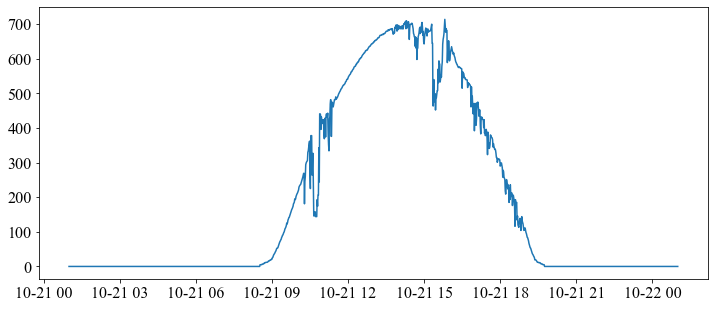

In [50]:
plt.plot(temp.iloc[:,1])

In [52]:
Sunrise = identify_SunriseAndSunset(temp)[0]
Sunset = identify_SunriseAndSunset(temp)[1]

temp = temp.resample('1T').mean().fillna(method = 'ffill') ##
I_rad = temp.loc[Sunrise[0]:Sunset[0]]

T = int(((Sunset - Sunrise).seconds)[0]/60)

z_train = np.reshape(np.array(dat_DF['tabTsense0'].iloc[159756:160429]),[-1,1])  
#Ideally,these two indices shoudd be determined automatically. However, this is done by hand actually.

nrow = len(z_train)
inp = dat_DF['ouTemperatureOutdoor'].iloc[159756:160429]


mu0 = [[dat_DF['tabTsense0'].iloc[159756]],[dat_DF['tabTsense0'].iloc[159756]]]
sigma0 = np.eye(2)

#known_par = [14.9586709,35.1750476,45.4942268,15.4581975,0.00280280788,-0.0363491767,0.999162344]  #Par from group 2
known_par = [37.7942674, 62.1937564, 57.8701421, 48.694451, 0.00121433866, -0.0363820435]           #Par from group 1

In [53]:
mu0

[[69.8], [69.8]]

In [54]:
init_par = [1,1,1]

In [55]:
object_fun_solar(init_par)

array([[5382501.92230334]])

In [56]:
#bound
bnds = ((None, None),(None, None),(None, None))
res = minimize(object_fun_solar,init_par,method = 'L-BFGS-B',bounds = bnds)

In [57]:
res

      fun: array([[-950.23521598]])
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.61484195, -0.98347073,  0.17273578])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 80
      nit: 18
   status: 0
  success: True
        x: array([-6.18980512e-04,  1.43912293e+00,  4.13529441e-01])

In [58]:
par_list = [[-6.18980512e-04,  1.43912293e+00,  4.13529441e-01]]

###### Test
Basically, the performance on the training dataset itself is always over-fitted

In [614]:
par = par_list[0]

In [615]:
## Prediction validation
Phi = np.eye(2)
Phi[0,0] = -1/(known_par[0]*known_par[2])+1
Phi[0,1] = 1/(known_par[0]*known_par[2])
Phi[1,0] = 1/(known_par[1]*known_par[2])
Phi[1,1] = -1*(1/(known_par[1]*known_par[2]) + 1/(known_par[1]*known_par[3]))+1

Ups = np.eye(2)  # Two input: Ambient temperautre, and Q_g
Ups[0,0] = 0
Ups[0,1] = 0
Ups[1,0] = 1/(known_par[1]*known_par[3])    
Ups[1,1] = 1/(known_par[1])    

cQ = np.eye(2)
cQ[0,0] = known_par[4]
cQ[1,1] = known_par[5]

#Observation process
A = np.array([[[0,1]]] * nrow)
cR = np.array([[0]])


inp = dat_DF['ouTemperatureOutdoor'].iloc[159756:160429]

In [616]:
## Q_solar
Q_solar = []
for i in range(T):
    Q_solar.append(I_rad.iloc[i,1]*par[0]*np.sin(np.pi * i/T+par[1])+par[2])

inp_final = np.reshape(np.array([list(inp),Q_solar]).T,(-1,2,1))

In [617]:
inp_final

array([[[51.6       ],
        [ 0.41046133]],

       [[51.8       ],
        [ 0.41045947]],

       [[51.9       ],
        [ 0.41045767]],

       ...,

       [[59.1       ],
        [ 0.41659156]],

       [[58.8       ],
        [ 0.41659363]],

       [[58.8       ],
        [ 0.41659562]]])

In [618]:
pred = [dat_DF['tabTsense0'].iloc[159755]]
prev_T = np.array([[pred[-1]],[pred[-1]]])

for i in range(len(I_rad)-1):
    
    inp_temp = inp_final[i]
    cur_T = np.dot(Phi,prev_T) + np.dot(Ups,inp_temp)
    #print(cur_T)
    pred.append(cur_T[1])
    prev_T = cur_T

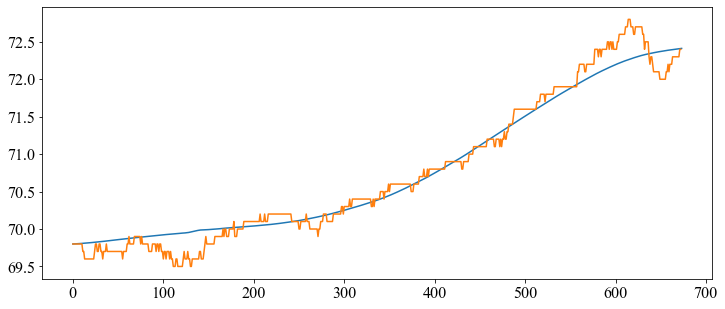

In [619]:
plt.plot(pred)
plt.plot(np.arange(T),dat_DF['tabTsense0'].iloc[159756:160429])
#plt.plot(np.arange(len(test)),dat_DF['ouTemperatureOutdoor'].iloc[166325:166325+7*60])

###### Case 2: 10/22

In [620]:
temp = solar_rad['2018-10-22 01:00:00':'2018-10-23 01:00:00']

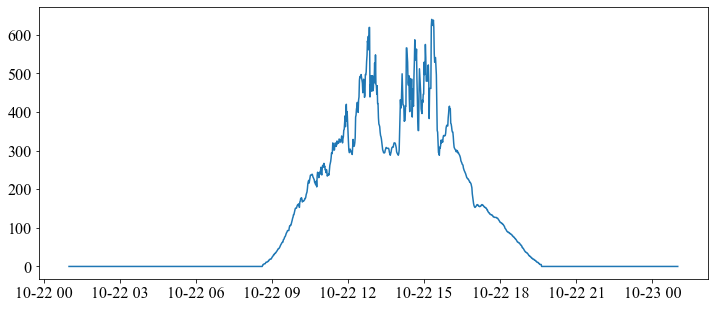

In [621]:
plt.plot(temp.iloc[:,1])

In [622]:
Sunrise = identify_SunriseAndSunset(temp)[0]
Sunset = identify_SunriseAndSunset(temp)[1]

In [623]:
temp = temp.resample('1T').mean().fillna(method = 'bfill')
I_rad = temp.loc[Sunrise[0]:Sunset[0]]

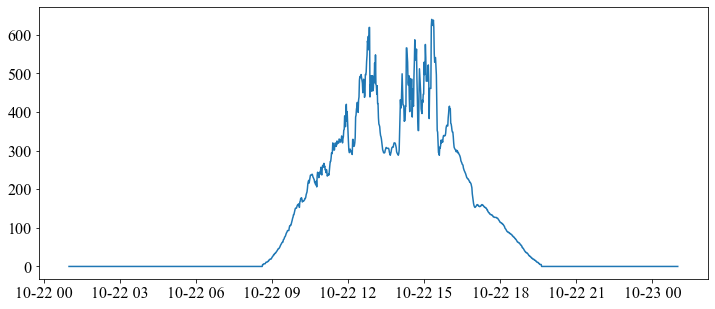

In [624]:
plt.plot(temp.iloc[:,1])

In [625]:
Sunrise, Sunset

(DatetimeIndex(['2018-10-22 08:39:00'], dtype='datetime64[ns]', name='Timestamp', freq=None),
 DatetimeIndex(['2018-10-22 19:38:00'], dtype='datetime64[ns]', name='Timestamp', freq=None))

In [626]:
Sunrise = identify_SunriseAndSunset(temp)[0]
Sunset = identify_SunriseAndSunset(temp)[1]
T = int(((Sunset - Sunrise).seconds)[0]/60)

z_train = np.reshape(np.array(dat_DF['tabTsense0'].iloc[161202:161862]),[-1,1])

nrow = len(z_train)
inp = dat_DF['ouTemperatureOutdoor'].iloc[161202:161862]


mu0 = [[dat_DF['tabTsense0'].iloc[161201]],[dat_DF['tabTsense0'].iloc[161201]]]
sigma0 = np.eye(2)

known_par = [37.7942674, 62.1937564, 57.8701421, 48.694451, 0.00121433866, -0.0363820435]           #Par from group 1

In [627]:
T

660

In [628]:
#bound
bnds = ((None, None),(None, None),(None, None))
res = minimize(object_fun_solar,init_par,method = 'L-BFGS-B',bounds = bnds)

In [629]:
res

      fun: array([[-1233.48899866]])
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.12921646, -0.11789325,  0.01823537])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 80
      nit: 19
   status: 0
  success: True
        x: array([-4.25118225e-04,  1.44874212e+00,  2.75416431e-01])

In [630]:
par_list.append([-4.25118225e-04,  1.44874212e+00,  2.75416431e-01])

###### Test

In [631]:
par = par_list[1]

In [632]:
## Prediction validation
Phi = np.eye(2)
Phi[0,0] = -1/(known_par[0]*known_par[2])+1
Phi[0,1] = 1/(known_par[0]*known_par[2])
Phi[1,0] = 1/(known_par[1]*known_par[2])
Phi[1,1] = -1*(1/(known_par[1]*known_par[2]) + 1/(known_par[1]*known_par[3]))+1

Ups = np.eye(2)  # Two input: Ambient temperautre, and Q_g
Ups[0,0] = 0
Ups[0,1] = 0
Ups[1,0] = 1/(known_par[1]*known_par[3])    
Ups[1,1] = 1/(known_par[1])    

cQ = np.eye(2)
cQ[0,0] = known_par[4]
cQ[1,1] = known_par[5]

#Observation process
A = np.array([[[0,1]]] * nrow)
cR = np.array([[0]])


inp = dat_DF['ouTemperatureOutdoor'].iloc[161202:161862]

In [633]:
## Q_solar
Q_solar = []
for i in range(T):
    Q_solar.append(I_rad.iloc[i,1]*par[0]*np.sin(np.pi * i/T+par[1])+par[2])

inp_final = np.reshape(np.array([list(inp),Q_solar]).T,(-1,2,1))

In [634]:
pred = [dat_DF['tabTsense0'].iloc[161201]]
prev_T = np.array([[pred[-1]],[pred[-1]]])

for i in range(len(I_rad)-1):
    
    inp_temp = inp_final[i]
    cur_T = np.dot(Phi,prev_T) + np.dot(Ups,inp_temp)
    #print(cur_T)
    pred.append(cur_T[1])
    prev_T = cur_T

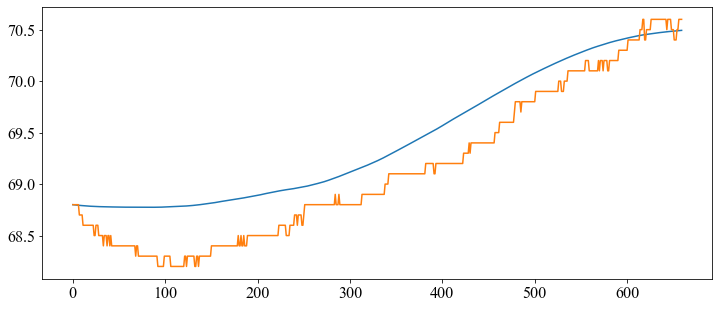

In [636]:
plt.plot(pred)
plt.plot(np.arange(T),dat_DF['tabTsense0'].iloc[161202:161862])
#plt.plot(np.arange(len(test)),dat_DF['ouTemperatureOutdoor'].iloc[166325:166325+7*60])

###### Case 3: 10/23

In [637]:
temp = solar_rad['2018-10-23 01:00:00':'2018-10-24 01:00:00']

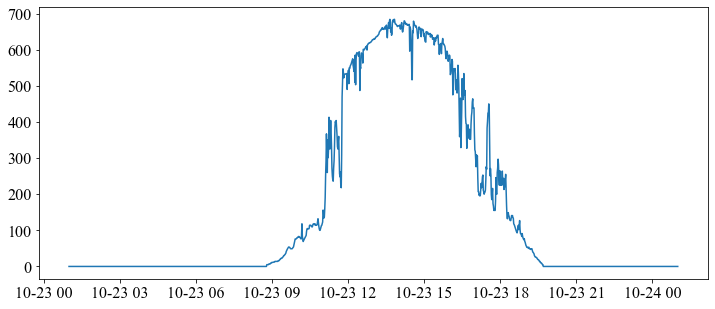

In [638]:
plt.plot(temp.iloc[:,1])

In [639]:
Sunrise = identify_SunriseAndSunset(temp)[0]
Sunset = identify_SunriseAndSunset(temp)[1]

In [640]:
temp = temp.resample('1T').mean().fillna(method = 'bfill')
I_rad = temp.loc[Sunrise[0]:Sunset[0]]

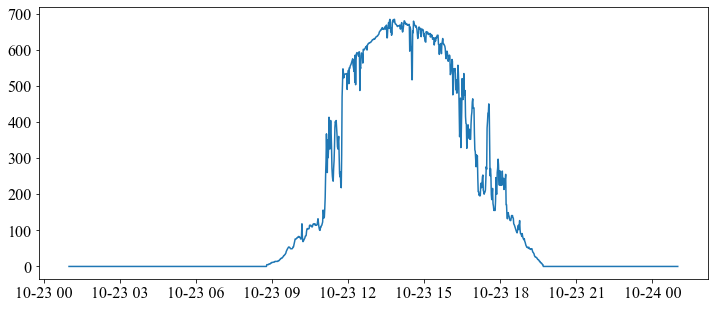

In [641]:
plt.plot(temp.iloc[:,1])

In [642]:
Sunrise, Sunset

(DatetimeIndex(['2018-10-23 08:48:00'], dtype='datetime64[ns]', name='Timestamp', freq=None),
 DatetimeIndex(['2018-10-23 19:42:00'], dtype='datetime64[ns]', name='Timestamp', freq=None))

In [643]:
dat_DF.iloc[163306]

Unnamed: 0                           163306
Local Time                 10/23/2018 19:42
ouTemperatureOutdoor                   62.7
ouInputVoltage                          241
ouInputCurrent                        0.301
ouPresentCompressorFreq                   0
iuAirFlowRate                             0
iuDAT                                     0
tabTsense0                             72.9
setpointCooling.0                        82
humidityIndoor.0                         59
SensibleCapacity                          0
tabTsense0_Category                      73
const                                  62.7
const_1                                   1
const_0                                   0
Name: 163306, dtype: object

In [644]:
Sunrise = identify_SunriseAndSunset(temp)[0]
Sunset = identify_SunriseAndSunset(temp)[1]
T = int(((Sunset - Sunrise).seconds)[0]/60)

z_train = np.reshape(np.array(dat_DF['tabTsense0'].iloc[162652:163306]),[-1,1])

nrow = len(z_train)
inp = dat_DF['ouTemperatureOutdoor'].iloc[162652:163306]


mu0 = [[dat_DF['tabTsense0'].iloc[162651]],[dat_DF['tabTsense0'].iloc[162651]]]
sigma0 = np.eye(2)
# Function to Calculate Likelihood

known_par = [14.9586709,35.1750476,45.4942268,15.4581975,0.00280280788,-0.0363491767,0.999162344]

In [645]:
init_par = [1,1,1]

In [646]:
#bound
bnds = ((None, None),(None, None),(None, None))
res = minimize(object_fun_solar,init_par,method = 'L-BFGS-B',bounds = bnds)

In [647]:
res

      fun: array([[-1212.71143583]])
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.29735929,  0.00038654, -0.00127329])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 164
      nit: 34
   status: 0
  success: True
        x: array([5.54262672e-04, 2.95234852e+00, 5.75587568e-01])

In [648]:
par_list.append([5.54262672e-04, 2.95234852e+00, 5.75587568e-01])

In [649]:
par_list

[[-0.000618980512, 1.43912293, 0.413529441],
 [-0.000425118225, 1.44874212, 0.275416431],
 [0.000554262672, 2.95234852, 0.575587568]]

###### Test result on 10/24

In [650]:
par = par_list[0]

In [651]:
temp = solar_rad['2018-10-24 01:00:00':'2018-10-25 01:00:00']

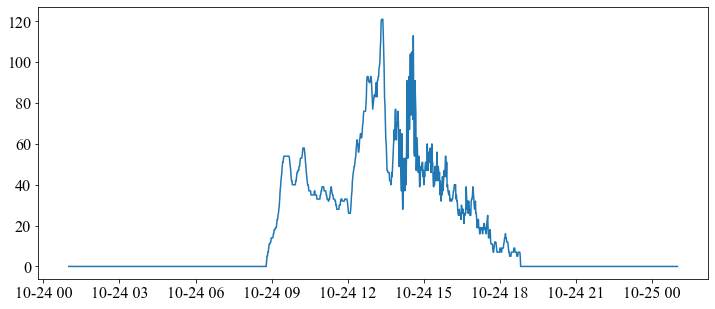

In [652]:
plt.plot(temp.iloc[:,1])

###### This day is specially cloudy

In [653]:
Sunrise = identify_SunriseAndSunset(temp)[0]
Sunset = identify_SunriseAndSunset(temp)[1]
T = int(((Sunset - Sunrise).seconds)[0]/60)

In [654]:
temp = temp.resample('1T').mean().fillna(method = 'bfill')
I_rad = temp.loc[Sunrise[0]:Sunset[0]]

In [655]:
T

600

In [656]:
## Prediction validation
Phi = np.eye(2)
Phi[0,0] = -1/(known_par[0]*known_par[2])+1
Phi[0,1] = 1/(known_par[0]*known_par[2])
Phi[1,0] = 1/(known_par[1]*known_par[2])
Phi[1,1] = -1*(1/(known_par[1]*known_par[2]) + 1/(known_par[1]*known_par[3]))+1

Ups = np.eye(2)  # Two input: Ambient temperautre, and Q_g
Ups[0,0] = 0
Ups[0,1] = 0
Ups[1,0] = 1/(known_par[1]*known_par[3])    
Ups[1,1] = 1/(known_par[1])    

cQ = np.eye(2)
cQ[0,0] = known_par[4]
cQ[1,1] = known_par[5]

#Observation process
A = np.array([[[0,1]]] * nrow)
cR = np.array([[0]])


inp = dat_DF['ouTemperatureOutdoor'].iloc[164092:164692]

In [657]:
## Q_solar
Q_solar = []
for i in range(T):
    Q_solar.append(I_rad.iloc[i,1]*par[0]*np.sin(np.pi * i/T+par[1])+par[2])

inp_final = np.reshape(np.array([list(inp),Q_solar]).T,(-1,2,1))

In [658]:
pred = [dat_DF['tabTsense0'].iloc[164091]]
prev_T = np.array([[pred[-1]],[pred[-1]]])

for i in range(len(I_rad)-1):
    
    inp_temp = inp_final[i]
    cur_T = np.dot(Phi,prev_T) + np.dot(Ups,inp_temp)
    #print(cur_T)
    pred.append(cur_T[1])
    prev_T = cur_T

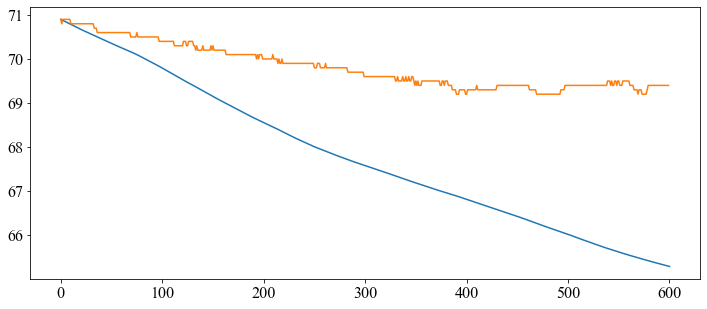

In [659]:
plt.plot(pred)
plt.plot(np.arange(T),dat_DF['tabTsense0'].iloc[164092:164692])
#plt.plot(np.arange(len(test)),dat_DF['ouTemperatureOutdoor'].iloc[166325:166325+7*60])

###### Test result on 10/26

In [707]:
par = par_list[0]

In [729]:
temp = solar_rad['2018-10-29 01:00:00':'2018-10-30 01:00:00']

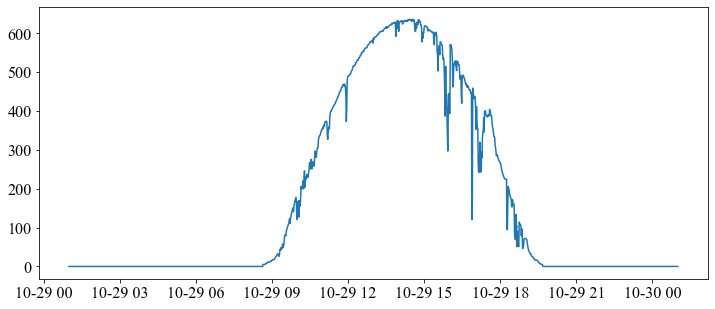

In [730]:
plt.plot(temp.iloc[:,1])

In [731]:
Sunrise = identify_SunriseAndSunset(temp)[0]
Sunset = identify_SunriseAndSunset(temp)[1]
T = int(((Sunset - Sunrise).seconds)[0]/60)

In [732]:
temp = temp.resample('1T').mean().fillna(method = 'bfill')
I_rad = temp.loc[Sunrise[0]:Sunset[0]]

In [743]:
Sunrise, Sunset

(DatetimeIndex(['2018-10-29 08:39:00'], dtype='datetime64[ns]', name='Timestamp', freq=None),
 DatetimeIndex(['2018-10-29 19:41:00'], dtype='datetime64[ns]', name='Timestamp', freq=None))

In [745]:
dat_DF.iloc[171283:171945]

,Unnamed: 0,Local Time,ouTemperatureOutdoor,ouInputVoltage,ouInputCurrent,ouPresentCompressorFreq,iuAirFlowRate,iuDAT,tabTsense0,setpointCooling.0,humidityIndoor.0,SensibleCapacity,tabTsense0_Category,const,const_1,const_0
171283,171283,10/29/2018 8:39,61.4,244.0,0.301,0.0,0.0,0.0,73.9,82.0,64.0,0.0,74,61.4,1.0,0.0
171284,171284,10/29/2018 8:40,61.4,243.0,0.301,0.0,0.0,0.0,73.9,82.0,64.0,0.0,74,61.4,1.0,0.0
171285,171285,10/29/2018 8:41,61.5,244.0,0.301,0.0,0.0,0.0,73.9,82.0,64.5,0.0,74,61.5,1.0,0.0
171286,171286,10/29/2018 8:42,61.6,243.0,0.301,0.0,0.0,0.0,73.9,82.0,64.5,0.0,74,61.6,1.0,0.0
171287,171287,10/29/2018 8:43,61.6,243.0,0.301,0.0,0.0,0.0,73.9,82.0,64.5,0.0,74,61.6,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171940,171940,10/29/2018 19:36,75.5,240.0,0.500,0.0,0.0,0.0,73.5,74.0,61.5,0.0,74,75.5,1.0,0.0
171941,171941,10/29/2018 19:37,75.4,240.0,0.500,0.0,0.0,0.0,73.4,74.0,61.0,0.0,74,75.4,1.0,0.0
171942,171942,10/29/2018 19:38,75.4,240.0,0.500,0.0,0.0,0.0,73.5,74.0,61.0,0.0,74,75.4,1.0,0.0
171943,171943,10/29/2018 19:39,75.4,240.0,0.500,0.0,0.0,0.0,73.6,74.0,61.5,0.0,74,75.4,1.0,0.0


In [746]:
## Prediction validation
Phi = np.eye(2)
Phi[0,0] = -1/(known_par[0]*known_par[2])+1
Phi[0,1] = 1/(known_par[0]*known_par[2])
Phi[1,0] = 1/(known_par[1]*known_par[2])
Phi[1,1] = -1*(1/(known_par[1]*known_par[2]) + 1/(known_par[1]*known_par[3]))+1

Ups = np.eye(2)  # Two input: Ambient temperautre, and Q_g
Ups[0,0] = 0
Ups[0,1] = 0
Ups[1,0] = 1/(known_par[1]*known_par[3])    
Ups[1,1] = 1/(known_par[1])    

cQ = np.eye(2)
cQ[0,0] = known_par[4]
cQ[1,1] = known_par[5]

#Observation process
A = np.array([[[0,1]]] * nrow)
cR = np.array([[0]])


inp = dat_DF['ouTemperatureOutdoor'].iloc[171283:171945]

In [747]:
## Q_solar
Q_solar = []
for i in range(T):
    Q_solar.append(I_rad.iloc[i,1]*par[0]*np.sin(np.pi * i/T+par[1])+par[2])

inp_final = np.reshape(np.array([list(inp),Q_solar]).T,(-1,2,1))

In [754]:
pred = [dat_DF['tabTsense0'].iloc[171282]]
prev_T = np.array([[pred[-1]],[pred[-1]]])

for i in range(len(I_rad)-1):
    
    inp_temp = inp_final[i]
    cur_T = np.dot(Phi,prev_T) + np.dot(Ups,inp_temp)
    #print(cur_T)
    pred.append(cur_T[1])
    prev_T = cur_T

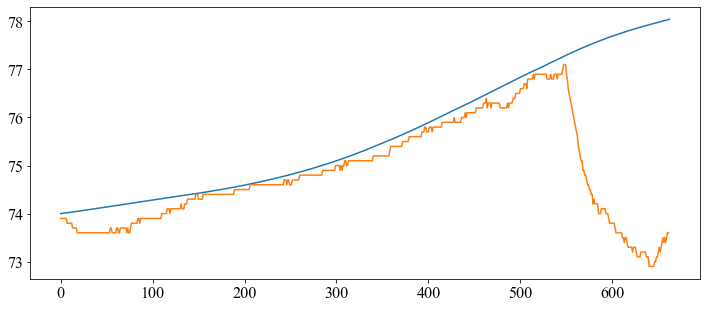

In [755]:
plt.plot(pred)
plt.plot(np.arange(T),dat_DF['tabTsense0'].iloc[171283:171945])
#plt.plot(np.arange(len(test)),dat_DF['ouTemperatureOutdoor'].iloc[166325:166325+7*60])

#### Step 3: Internal heat gain estimation
In the previous step, internal heat is assumed to be a constant.To be more specific, internal heat gain for a certain day could be divided to two part: **one const component** and **time-variant compoenent**. In addition, this time-variant component have a zero average!!(As shown in the following plots.)



Therefore, we couldd further estimate this time-variant component.Here, I assume 24 hourly values to represent this time-variant components. Then, I just need to estimate these 24 values.(You could also use 1440 minutely values to do this)

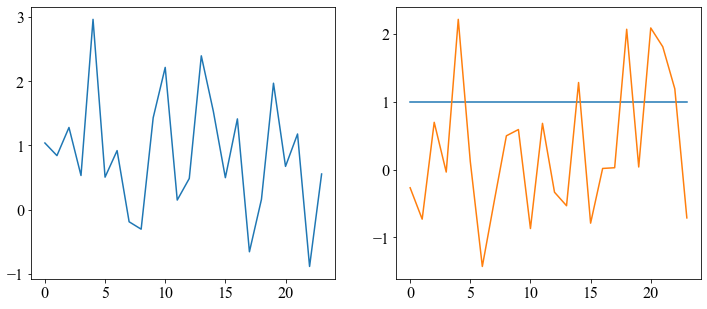

In [764]:
plt.subplot(1,2,1)
plt.plot([1]*24+np.random.randn(24)*1)

plt.subplot(1,2,2)
plt.plot([1]*24)
plt.plot(np.random.randn(24)*1)

In [75]:
def object_fun_solar(par): 
    ## Q_solar
    Q_final = [0]*1440
    for i,q in enumerate(Q_base):
        hour = int(i/60)
        Q_final[i] = q + par[hour] 
        

    inp_final = np.reshape(np.array([list(inp),Q_final]).T,(-1,2,1))
    
    kf = KFilter1(nrow,z_train,A,mu0,sigma0,Phi,Ups,np.array([[0]]),cQ,cR,inp_final)
        
    return kf['like']

###### Case 1: 10/21 

In [77]:
temp = solar_rad['2018-10-21 01:00:00':'2018-10-22 01:00:00']

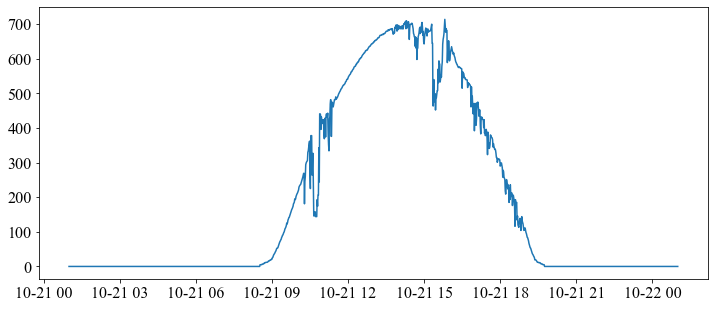

In [78]:
plt.plot(temp.iloc[:,1])

In [79]:
known_par = [37.7942674, 62.1937564, 57.8701421, 48.694451, 0.00121433866, -0.0363820435]           #Par from group 1
Known_par2 = [-0.000618980512, 1.43912293, 0.413529441]

In [80]:
Phi = np.eye(2)
Phi[0,0] = -1/(known_par[0]*known_par[2])+1
Phi[0,1] = 1/(known_par[0]*known_par[2])
Phi[1,0] = 1/(known_par[1]*known_par[2])
Phi[1,1] = -1*(1/(known_par[1]*known_par[2]) + 1/(known_par[1]*known_par[3]))+1

Ups = np.eye(2)  # Two input: Ambient temperautre, and Q_g
Ups[0,0] = 0
Ups[0,1] = 0
Ups[1,0] = 1/(known_par[1]*known_par[3])    
Ups[1,1] = 1/(known_par[1])    

cQ = np.eye(2)
cQ[0,0] = known_par[4]
cQ[1,1] = known_par[5]

#Observation process
A = np.array([[[0,1]]] * nrow)
cR = np.array([[0]])

In [81]:
## Q_solar
Sunrise = identify_SunriseAndSunset(temp)[0]
Sunset = identify_SunriseAndSunset(temp)[1]

temp = temp.resample('1T').mean().fillna(method = 'ffill')
I_rad = temp.loc[Sunrise[0]:Sunset[0]]

T = int(((Sunset - Sunrise).seconds)[0]/60)

Q_solar = []
for i in range(T):
    Q_solar.append(I_rad.iloc[i,1]*Known_par2[0]*np.sin(np.pi * i/T+Known_par2[1])+Known_par2[2])

Q_base = [0]*(Sunrise.hour*60+Sunrise.minute)[0] + Q_solar
Q_base = Q_base + [0] *(1440-len(Q_base))

In [82]:
z_train = np.reshape(np.array(dat_DF['tabTsense0'].iloc[159244:159244+1440]),[-1,1])  
#Ideally,these two indices shoudd be determined automatically. However, this is done by hand actually.

nrow = len(z_train)
inp = dat_DF['ouTemperatureOutdoor'].iloc[159244:159244+1440]


mu0 = [[dat_DF['tabTsense0'].iloc[159243]],[dat_DF['tabTsense0'].iloc[159243]]]
sigma0 = np.eye(2)

In [83]:
mu0

[[72.9], [72.9]]

In [84]:
len(Q_base)

1440

In [85]:
init_par = [1]*24

In [86]:
object_fun_solar(init_par)

array([[-2220.53663726]])

In [87]:
#bound
bnds = ((None, None),(None, None),(None, None),(None, None),(None, None),(None, None),(None, None),(None, None),
       (None, None),(None, None),(None, None),(None, None),(None, None),(None, None),(None, None),(None, None),
        (None, None),(None, None),(None, None),(None, None),(None, None),(None, None),(None, None),(None, None))
res = minimize(object_fun_solar,init_par,method = 'L-BFGS-B',bounds = bnds)

In [88]:
res

      fun: array([[-2357.46149235]])
 hess_inv: <24x24 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.31876732e-03, -3.63797881e-04,  3.63797881e-04, -7.27595761e-04,
        0.00000000e+00,  4.54747351e-04,  4.09272616e-04,  1.09139364e-03,
       -1.36424205e-04,  7.27595761e-04,  4.09272616e-04, -1.86446414e-03,
       -1.00044417e-03,  4.09272616e-04, -1.50066626e-03, -4.54747351e-05,
       -5.91171556e-04, -7.27595761e-04, -5.45696821e-04, -5.91171556e-04,
       -1.36424205e-04, -7.27595761e-04, -2.72848411e-04, -4.54747351e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 125
      nit: 4
   status: 0
  success: True
        x: array([-0.14400863, -0.02105493,  0.07408876,  0.06925191, -0.03718782,
       -0.02415154, -0.03192856,  0.28279922, -0.27574175, -0.13268696,
        0.06467142,  0.20510332, -0.35748472,  0.16871261, -0.05553357,
       -0.07290773, -0.00523867,  0.03359958,  0.27512971, -0.36768241,
       -0.09253595,  0.34

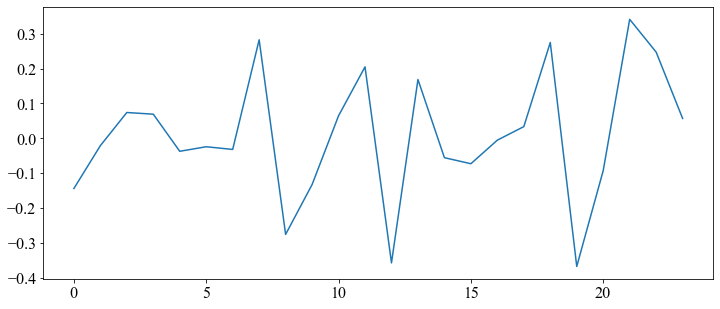

In [858]:
plt.plot(res['x'])

Testing on 10/21

In [89]:
re_par = res['x']

In [90]:
Q_final = [0]*1440
for i,q in enumerate(Q_base):
    hour = int(i/60)
    Q_final[i] = q + re_par[hour] 


inp_final = np.reshape(np.array([list(inp),Q_final]).T,(-1,2,1))

In [91]:
pred = [dat_DF['tabTsense0'].iloc[159244]]
prev_T = np.array([[pred[-1]],[pred[-1]]])

for i in range(1439):
    
    inp_temp = inp_final[i]
    cur_T = np.dot(Phi,prev_T) + np.dot(Ups,inp_temp)
    #print(cur_T)
    pred.append(cur_T[1])
    prev_T = cur_T

In [92]:
len(pred)

1440

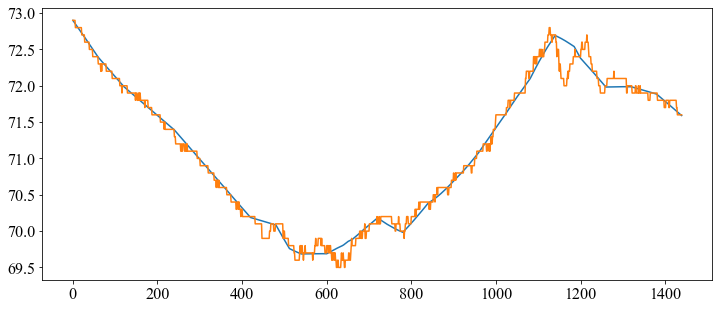

In [93]:
plt.plot(pred)
plt.plot(np.arange(1440),dat_DF['tabTsense0'].iloc[159244:159244+1440])
#plt.plot(np.arange(len(test)),dat_DF['ouTemperatureOutdoor'].iloc[166325:166325+7*60])

###### Test  on 10/22

In [922]:
re_par = res['x']

In [950]:
temp = solar_rad['2018-10-22 01:00:00':'2018-10-23 01:00:00']

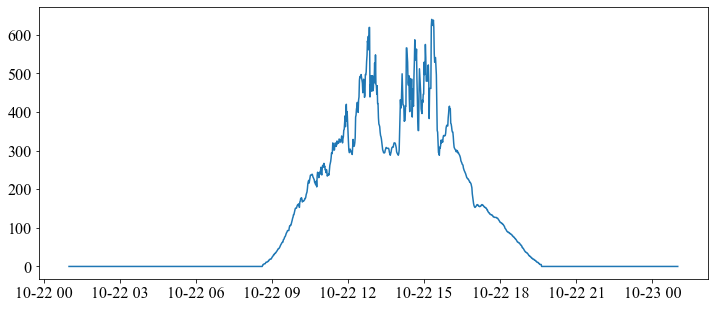

In [951]:
plt.plot(temp.iloc[:,1])

In [952]:
Sunrise = identify_SunriseAndSunset(temp)[0]
Sunset = identify_SunriseAndSunset(temp)[1]
T = int(((Sunset - Sunrise).seconds)[0]/60)

In [953]:
temp = temp.resample('1T').mean().fillna(method = 'bfill')
I_rad = temp.loc[Sunrise[0]:Sunset[0]]

In [954]:
## Q_solar
Q_solar = []
for i in range(T):
    Q_solar.append(I_rad.iloc[i,1]*Known_par2[0]*np.sin(np.pi * i/T+Known_par2[1])+Known_par2[2])

In [955]:
Q_base = [0]*(Sunrise.hour*60+Sunrise.minute)[0] + Q_solar
Q_base = Q_base + [0] *(1440-len(Q_base))

In [956]:
Q_final = [0]*1440
for i,q in enumerate(Q_base):
    hour = int(i/60)
    Q_final[i] = q + re_par[hour] 

In [957]:
z_train = np.reshape(np.array(dat_DF['tabTsense0'].iloc[159244+1440:159244+1440*2]),[-1,1])  
#Ideally,these two indices shoudd be determined automatically. However, this is done by hand actually.

nrow = len(z_train)
inp = dat_DF['ouTemperatureOutdoor'].iloc[159244+1440:159244+1440*2]


mu0 = [[dat_DF['tabTsense0'].iloc[159243+1440]],[dat_DF['tabTsense0'].iloc[159243+1440]]]
sigma0 = np.eye(2)

In [958]:
inp_final = np.reshape(np.array([list(inp),Q_final]).T,(-1,2,1))

In [960]:
pred2 = [dat_DF['tabTsense0'].iloc[159244+1440]]
prev_T = np.array([[pred2[-1]],[pred2[-1]]])

for i in range(1439):
    
    inp_temp = inp_final[i]
    cur_T = np.dot(Phi,prev_T) + np.dot(Ups,inp_temp)
    #print(cur_T)
    pred2.append(cur_T[1])
    prev_T = cur_T

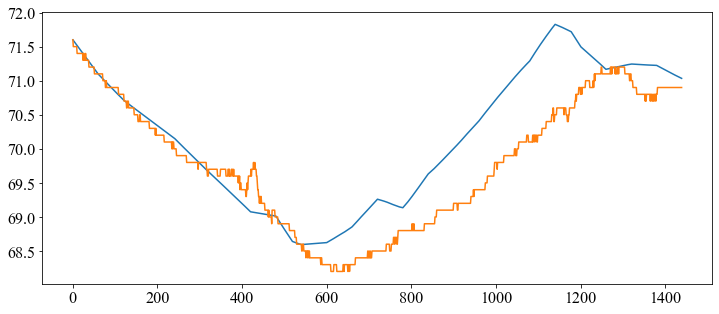

In [961]:
plt.plot(pred2)
plt.plot(np.arange(1440),dat_DF['tabTsense0'].iloc[159244+1440:159244+2880])
#plt.plot(np.arange(len(test)),dat_DF['ouTemperatureOutdoor'].iloc[166325:166325+7*60])

###### Test  on 10/23

In [154]:
re_par = res['x']

In [155]:
temp = solar_rad['2018-10-23 01:00:00':'2018-10-24 01:00:00']

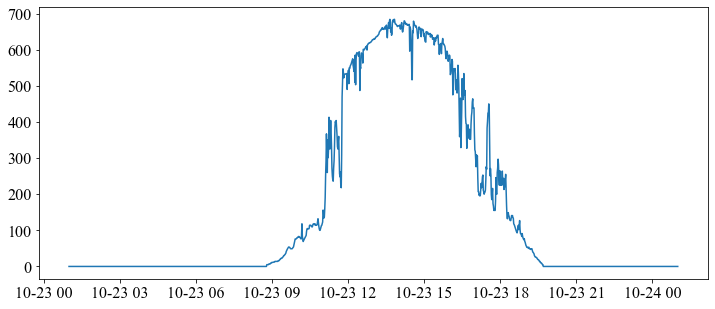

In [156]:
plt.plot(temp.iloc[:,1])

In [157]:
Sunrise = identify_SunriseAndSunset(temp)[0]
Sunset = identify_SunriseAndSunset(temp)[1]
T = int(((Sunset - Sunrise).seconds)[0]/60)

In [158]:
temp = temp.resample('1T').mean().fillna(method = 'bfill')
I_rad = temp.loc[Sunrise[0]:Sunset[0]]

In [159]:
## Q_solar
Q_solar = []
for i in range(T):
    Q_solar.append(I_rad.iloc[i,1]*Known_par2[0]*np.sin(np.pi * i/T+Known_par2[1])+Known_par2[2])

In [160]:
Q_base = [0]*(Sunrise.hour*60+Sunrise.minute)[0] + Q_solar
Q_base = Q_base + [0] *(1440-len(Q_base))

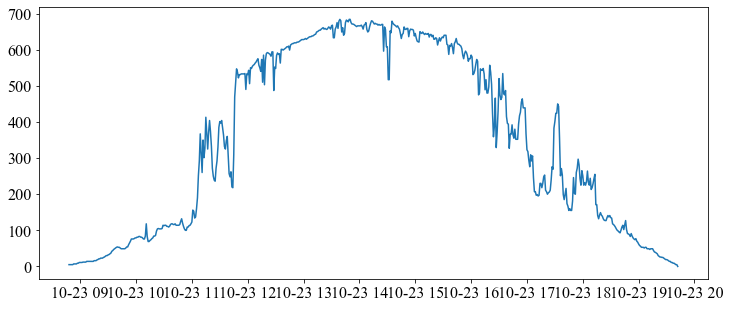

In [161]:
plt.plot(I_rad.iloc[:,1])

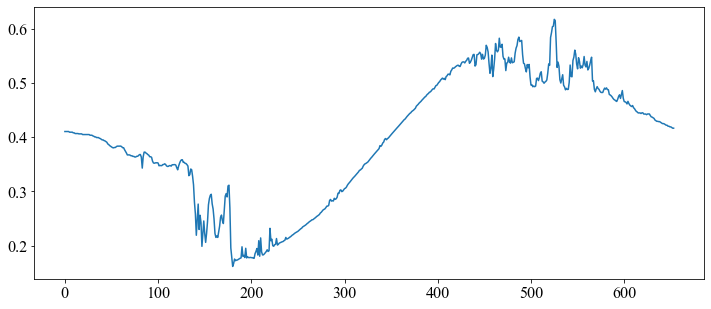

In [162]:
plt.plot(Q_solar)

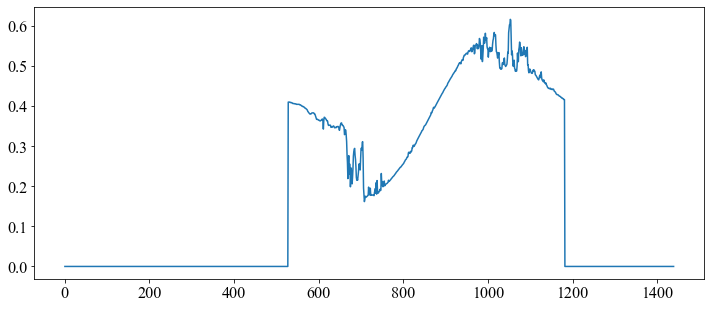

In [163]:
plt.plot(Q_base)

In [164]:
Q_final = [0]*1440
for i,q in enumerate(Q_base):
    hour = int(i/60)
    Q_final[i] = q + re_par[hour] 

In [165]:
159244+2880

162124

In [166]:
z_train = np.reshape(np.array(dat_DF['tabTsense0'].iloc[162124:162124+1440]),[-1,1])  
#Ideally,these two indices shoudd be determined automatically. However, this is done by hand actually.

nrow = len(z_train)
inp = dat_DF['ouTemperatureOutdoor'].iloc[162124:162124+1440]

In [167]:
inp_final = np.reshape(np.array([list(inp),Q_final]).T,(-1,2,1))

In [168]:
pred2 = [dat_DF['tabTsense0'].iloc[162124]]
prev_T = np.array([[pred2[-1]],[pred2[-1]]])

for i in range(1439):
    
    inp_temp = inp_final[i]
    cur_T = np.dot(Phi,prev_T) + np.dot(Ups,inp_temp)
    #print(cur_T)
    pred2.append(cur_T[1])
    prev_T = cur_T

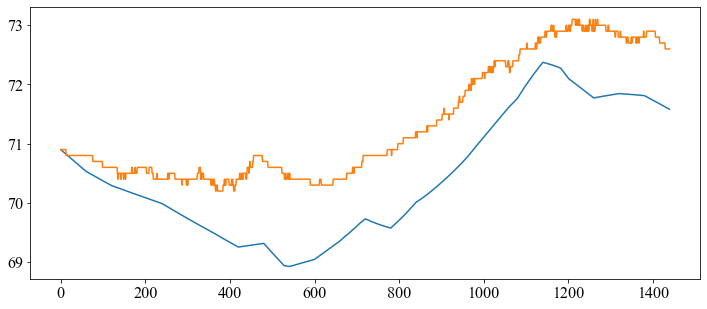

In [169]:
plt.plot(pred2)
plt.plot(np.arange(1440),dat_DF['tabTsense0'].iloc[162124:162124+1440])
#plt.plot(np.arange(len(test)),dat_DF['ouTemperatureOutdoor'].iloc[166325:166325+7*60])

###### Test  on 10/24

In [170]:
re_par = res['x']

In [171]:
temp = solar_rad['2018-10-24 01:00:00':'2018-10-25 01:00:00']

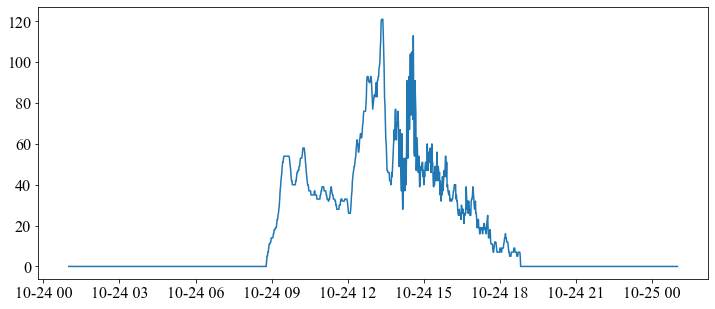

In [172]:
plt.plot(temp.iloc[:,1])

In [173]:
Sunrise = identify_SunriseAndSunset(temp)[0]
Sunset = identify_SunriseAndSunset(temp)[1]
T = int(((Sunset - Sunrise).seconds)[0]/60)

In [174]:
temp = temp.resample('1T').mean().fillna(method = 'bfill')
I_rad = temp.loc[Sunrise[0]:Sunset[0]]

In [175]:
## Q_solar
Q_solar = []
for i in range(T):
    Q_solar.append(I_rad.iloc[i,1]*Known_par2[0]*np.sin(np.pi * i/T+Known_par2[1])+Known_par2[2])

In [176]:
Q_base = [0]*(Sunrise.hour*60+Sunrise.minute)[0] + Q_solar
Q_base = Q_base + [0] *(1440-len(Q_base))

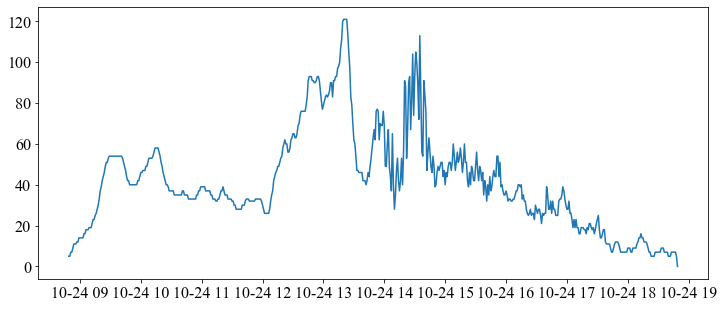

In [177]:
plt.plot(I_rad.iloc[:,1])

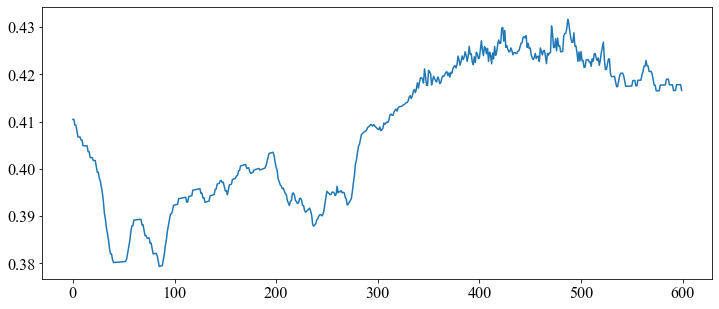

In [178]:
plt.plot(Q_solar)

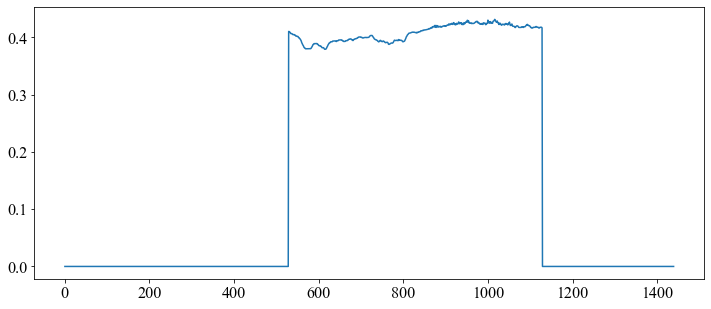

In [179]:
plt.plot(Q_base)

In [180]:
Q_final = [0]*1440
for i,q in enumerate(Q_base):
    hour = int(i/60)
    Q_final[i] = q + re_par[hour] 

In [165]:
159244+2880

162124

In [181]:
162124+1440

163564

In [182]:
z_train = np.reshape(np.array(dat_DF['tabTsense0'].iloc[163564:163564+1440]),[-1,1])  
#Ideally,these two indices shoudd be determined automatically. However, this is done by hand actually.

nrow = len(z_train)
inp = dat_DF['ouTemperatureOutdoor'].iloc[163564:163564+1440]

In [183]:
inp_final = np.reshape(np.array([list(inp),Q_final]).T,(-1,2,1))

In [184]:
pred2 = [dat_DF['tabTsense0'].iloc[163564]]
prev_T = np.array([[pred2[-1]],[pred2[-1]]])

for i in range(1439):
    
    inp_temp = inp_final[i]
    cur_T = np.dot(Phi,prev_T) + np.dot(Ups,inp_temp)
    #print(cur_T)
    pred2.append(cur_T[1])
    prev_T = cur_T

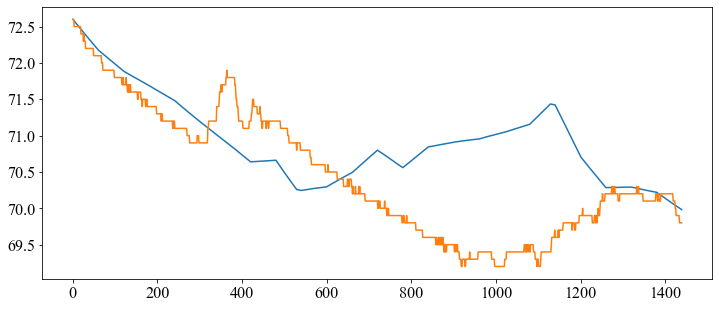

In [186]:
plt.plot(pred2)
plt.plot(np.arange(1440),dat_DF['tabTsense0'].iloc[163564:163564+1440])
#plt.plot(np.arange(len(test)),dat_DF['ouTemperatureOutdoor'].iloc[166325:166325+7*60])

**This should be testing using my data!!!**